## Importing libraries

In [4]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision.utils as vutils
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torchvision4ad.datasets import MVTecAD
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torch_intermediate_layer_getter import IntermediateLayerGetter
from torchvision.utils import save_image
from torch.autograd import Function
from torch.utils.data import DataLoader
from torch.utils.data import Subset

import cudaq
import time

# Preprocessing

In [5]:
print(*[torch.cuda.get_device_properties(f'cuda:{i}') for i in range(5)], sep ='\n')

_CudaDeviceProperties(name='NVIDIA L40', major=8, minor=9, total_memory=45468MB, multi_processor_count=142, uuid=12b4f9ea-94c1-8a11-14cc-898707fe6dfe, L2_cache_size=96MB)
_CudaDeviceProperties(name='NVIDIA H100 PCIe', major=9, minor=0, total_memory=81089MB, multi_processor_count=114, uuid=d8c6370a-667a-a06f-30e1-d216d1e61d69, L2_cache_size=50MB)
_CudaDeviceProperties(name='NVIDIA H100 PCIe', major=9, minor=0, total_memory=81089MB, multi_processor_count=114, uuid=f0ebe4a6-43e2-fad3-bc5c-13c4c8c8755b, L2_cache_size=50MB)
_CudaDeviceProperties(name='NVIDIA A10', major=8, minor=6, total_memory=22598MB, multi_processor_count=72, uuid=9a16e980-88b7-c126-f76e-c87d484a60c1, L2_cache_size=6MB)
_CudaDeviceProperties(name='NVIDIA A10', major=8, minor=6, total_memory=22598MB, multi_processor_count=72, uuid=e8759db4-df10-fbaf-f89d-0e19feca09ab, L2_cache_size=6MB)


In [6]:
batch_size = 64

In [7]:
class GridDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        # self.dataset = MVTecAD(root_dir, 'grid', train=False, download=False)
        self.dataset = ImageFolder('mvtec_ad/grid/train/')

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.transform(img)


def process_grid_images():
    dataset = GridDataset(root_dir='./mvtec_ad')
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    patches_final = []
    for batch_idx, images in enumerate(dataloader):
        assert images.shape[1:] == (1, 512, 512), f"Batch {batch_idx} has incorrect dimensions: {images.shape}"

        # Extract patches for all images in the batch
        patches = [
            images[:, :, i:i+128, j:j+128]
            for i in range(0, images.shape[2], 128)
            for j in range(0, images.shape[3], 128)
        ]
        patches_final.extend(patches)

        print(f"Processed batch {batch_idx}: {len(patches)} patches extracted per image")

    return patches_final, dataloader, dataset


In [8]:
patches_final, dataloader, dataset=process_grid_images()
len(dataset)

Processed batch 0: 16 patches extracted per image


256

In [9]:
patches_final[0].shape

torch.Size([256, 1, 128, 128])

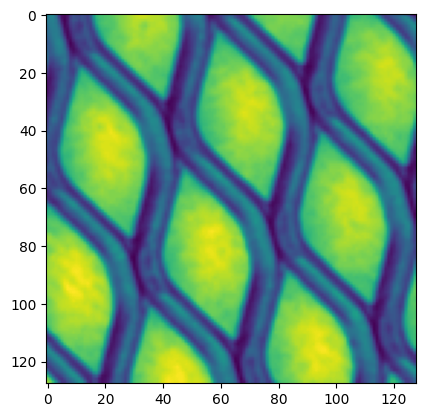

In [10]:
plt.imshow(patches_final[1][0][0])

In [11]:
#obsolute code
# class GridDatasetPatches(torch.utils.data.Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         img = self.dataset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img



In [12]:
# # Can be used for troubleshooting dataloader
# images = torch.randn(100, 1, 512, 512)  # 100 grayscale images of size 128x128

# # Create the dataset
# patch_size = 128
# # dataset = GridDatasetPatches1(images, patch_size=patch_size)

# # Use DataLoader for parallel processing
# dataloader = torch.utils.data.DataLoader(patches_final, batch_size=64, shuffle=False, num_workers=1)

# # Iterate over the dataloader
# for batch_idx, patches in enumerate(dataloader):
#     print(f"Batch {batch_idx}: {patches.shape}")


In [13]:
transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
dataset_mv = ImageFolder('mvtec_ad/grid/train/', transform=transform)
dataloader_mv = DataLoader(dataset_mv, batch_size= batch_size)
dataset_mv.classes


['rotated']

torch.Size([64, 1, 512, 512])


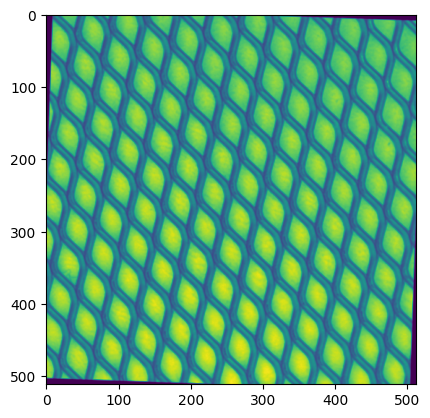

In [14]:
img = next(iter(dataloader_mv))
print(img[0].shape)
plt.imshow(img[0][0].squeeze())

## Declaring Parameters

In [15]:
workers = 20
image_size =128
nc =1
nz = 64  # Latent vector size
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
beta1 = 0.5  # Adam optimizer beta1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(device)}")

Using device: NVIDIA L40


In [16]:
# Flatten patches into a single tensor
test_dataset = torch.cat([patches for patches in patches_final])

# Create DataLoader with optimized settings
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)

# Print dataset and dataloader details for debugging
print(f"Test dataset size: {len(test_dataset)}")
# print(len(list(enumerate(test_dataloader))[0])[0].shape)
print(list(enumerate(test_dataloader))[-2][1].shape)


Test dataset size: 4096


torch.Size([64, 1, 128, 128])


<class 'torch.Tensor'>


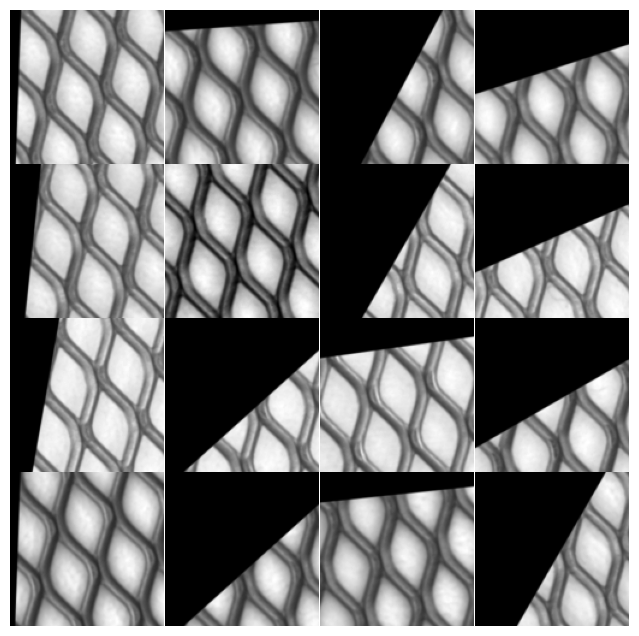

cuda


In [17]:
# Get a batch of images from the dataloader
data_iter = iter(test_dataloader)
images = next(data_iter).to(device)

# Plot 4 images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
print(type(images))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i][0].cpu(), cmap='gray',)
        ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
print(device)
## This demosntrates the patches are transfered to gpu

In [18]:
# Calculate seed_size and seed
seed_size = int(image_size / 16)  # Downsampling factor
input_features = ngf * 8 * seed_size * seed_size  # Initial tensor size

print(f"Seed size: {seed_size}, Seed: {input_features}")


Seed size: 8, Seed: 32768


In [19]:
import torch
import torch.nn as nn

class Generator(nn.Module): #modify this; first layer is linear , and then reshape (check if batchnorm and relu were used after this layer)
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a linear layer
            nn.Linear(nz,input_features,bias=True),
            nn.Unflatten(1,(ngf*8,seed_size,seed_size)),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 5, 2, 2, 1, bias=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 5, 2, 2, 1, bias=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf,nc,5,2,2,1,bias=True),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(1).to(device)

# Handle multi-GPU if available
# if (device.type == 'cuda') :
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)

# Print the model architecture
print(netG)


Generator(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=32768, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(512, 8, 8))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(64, 1, kernel_size=(5,

Output shape: torch.Size([16, 1, 128, 128])
torch.Size([32, 1, 128, 128])


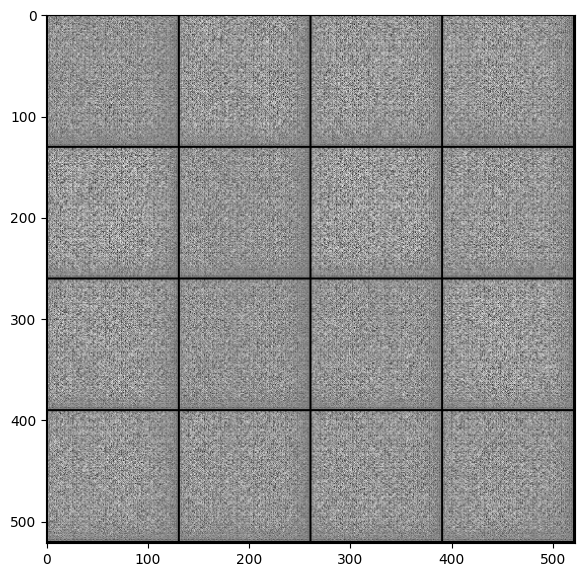

In [20]:
# Dummy input: Latent vector of size (batch_size, nz)
dummy_input = torch.randn(16, nz, device=device)  # Batch size = 16
output = netG(dummy_input)
print(f"Output shape: {output.shape}")  # Expected: (16, nc, image_size, image_size)

"""
Remove
"""

input=torch.randn(32,nz).to(device)

output=netG(input)
print(output.shape)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

# plt.imshow(input.cpu().detach().numpy(),cmap='gray')
plt.imshow(np.transpose(vutils.make_grid(output.cpu()[:16], nrow=4, normalize=True)))
# plt.subplot(1,2,2)
# plt.imshow(np.transpose(vutils.make_grid(patch_ensemble.to(device),nrow=4, padding=3, normalize=True).cpu()))


Generator done.
Try after loadeing



In [21]:
netG.load_state_dict(torch.load('/home/cudaq/files/generator_no_rotation.pth',map_location=torch.device(device)))


/tmp/ipykernel_1299578/1981628834.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('/home/cudaq/files/generator_no_rotation.pth',map_locat

<All keys matched successfully>

In [22]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 5, 2, 2, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 5, 2, 2, bias=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 5, 2, 2, bias=True),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 5, 2, 2, bias=True),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Flatten(start_dim=1),
            nn.Linear(ndf*8*seed_size*seed_size,1,bias=True),
            #nn.Conv2d(ndf * 8, 1, 5, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
# Create the Discriminator
netD = Discriminator(1).to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
# print(netD)
# netD(test_dataloader)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=32768, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [23]:
netD.load_state_dict(torch.load('/home/cudaq/files/discriminator_no_rotation.pth',map_location=torch.device(device)))


/tmp/ipykernel_1299578/1476463057.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netD.load_state_dict(torch.load('/home/cudaq/files/discriminator_no_rotation.pth',map_l

<All keys matched successfully>

In [24]:
# import torchvision.models as models
# from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

# # Load a pre-trained model
# model = models.resnet50(pretrained=True)

# # Define which nodes to return
# return_nodes = {
#     'layer4.2.relu': 'relu_layer4',
#     'layer3.5.relu': 'relu_layer3'
# }

# # Create the feature extractor
# extractor = create_feature_extractor(model, return_nodes)

# # Prepare a sample input tensor (batch size = 1, channels = 3, height = 224, width = 224)
# input_tensor = torch.rand(1, 3, 224, 224)

# # Use the extractor to obtain features
# features = extractor(input_tensor)
# print(features['relu_layer3'].shape)

In [25]:
# model

In [26]:
# get_graph_node_names(model)

In [30]:
from torchvision.models.feature_extraction import create_feature_extractor
import torch
import torch.nn as nn
import numpy as np

# Extract intermediate layers
return_layers = {'main.10': 'intermediate_layer_10'}

# L1 error function
def l1_error(x, y):
    assert x.shape == y.shape, f"Shape mismatch: {x.shape} vs {y.shape}"
    return torch.sum(torch.abs(x - y), dim=(-1, -2, -3))

# L2 error function
def l2_error(x, y):
    assert x.shape == y.shape, f"Shape mismatch: {x.shape} vs {y.shape}"
    # product = x[0].numel()
    return torch.mean((x - y) ** 2, dim=(-1, -2, -3)) # * product

# Quantum parameters
num_qubits = int(np.log2(nz))
num_an_qubits = 1
num_qubits += num_an_qubits  # Include ancillary qubits if needed
shift = torch.tensor(torch.pi / 2, device= device)
depth = 6


In [70]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int,an_qubit_count:int,depth: int):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int,x: np.ndarray, thetas: np.ndarray):
            qubits = cudaq.qvector(qubit_count)
            for i in range(qubit_count):
                ry(x[i], qubits[i])
            for d_num in range(depth):
               for j in range(3):
                 number=(d_num*qubit_count*3)+(j*qubit_count)
                 if (j==0):
                   for qubit in range(qubit_count):
                      rx(thetas[number+qubit],qubits[qubit])

                 if(j==1):
                   for qubit in range(qubit_count):
                     rz(thetas[number+qubit],qubits[qubit])

                 if(j==2):
                   for qubit in range(qubit_count):
                     rx.ctrl(thetas[number+qubit],qubits[qubit],qubits[((qubit+1)%qubit_count)])
            for i in range(qubit_count):
             mx(qubits[i])
            # cudaq.draw(qubits)
        self.kernel = kernel
        self.qubit_count = qubit_count
        self.an_qubit_count = an_qubit_count

    def run(self, x, theta_vals_list) :
        qubit_count = [self.qubit_count for _ in range(theta_vals_list.shape[0])]

        results=cudaq.sample(self.kernel,qubit_count,x,theta_vals_list) #
        results_final=[]
        bitstrings=[f"{i:06b}" for i in range(nz)]
        for item in results:
           item_1={}
           for k,v in item.items():
             final_v=float(v)/sum(item.values())
             #if final_v<float(1/len(list(item.values()))):
               #final_v=-final_v
             item_1[k]=final_v
           for bitstring in bitstrings:
             if bitstring not in item_1:
               item_1[bitstring]=0

           item_values=item_1.values()
           item_values=list(item_values)
           #scaling all values from -1 to 1
           for i in range(len(item_values)):
            item_values[i]=2*(item_values[i]-min(item_values))/(max(item_values)-min(item_values))-1
           item_values=item_values[:nz]

           results_final.append((item_values))
        results_final=[torch.Tensor(list1) for list1 in results_final]
        results_final=torch.stack(results_final,dim=0).to(device)
        return results_final

    @staticmethod
    def forward(ctx,x, thetas, quantum_circuit, shift):

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        theta_vals_list=[]
        for j in range(x.shape[0]):
          theta_vals_list.append(thetas)
        theta_vals_list=torch.stack(theta_vals_list,dim=0)
        results = ctx.quantum_circuit.run(x,theta_vals_list)
        #print("forward results done")
        ctx.save_for_backward(x,theta_vals_list,results)
        return results



    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference"""
        print("enter backprop")
        x,thetas,results = ctx.saved_tensors
        gradients_jacobian_theta = torch.zeros((results.shape[0],results.shape[1],thetas.shape[1]), device=device)
        gradients_jacobian_x=torch.zeros((results.shape[0],results.shape[1],x.shape[1]), device=device)
        print(thetas.shape)
        for i in range(thetas.shape[1]):
            thetas_plus = thetas.clone()
            thetas_plus[:,i] += ctx.shift
            results_plus=ctx.quantum_circuit.run(x,thetas_plus)
            thetas_minus = thetas.clone()
            thetas_minus[:,i] -= ctx.shift
            results_minus=ctx.quantum_circuit.run(x,thetas_minus)
            gradients_jacobian_theta[:,:,i] = (results_plus - results_minus) / (2 * ctx.shift)
        gradients_theta=torch.zeros((results.shape[0],thetas.shape[1]),device=device)
        print(x.shape)
        for k in range(x.shape[0]):
          gradients_theta[k]=grad_output[k].reshape(1,grad_output[k].shape[0])@gradients_jacobian_theta[k]
        """using torch autograd jacobian somehow gives me grad wrt x values as zero; 
           so calculating gradients wrt x similarly as gradients wrt thetas"""
        for i in range(x.shape[1]):
            x_plus = x.clone()
            x_plus[:,i] += ctx.shift
            results_plus=ctx.quantum_circuit.run(x_plus,thetas)
            x_minus = x.clone()
            x_minus[:,i] -= ctx.shift
            results_minus=ctx.quantum_circuit.run(x_minus,thetas)
            gradients_jacobian_x[:,:,i] = (results_plus - results_minus) / (2 * ctx.shift)
        gradients_x=torch.zeros((results.shape[0],x.shape[1]),device=device)
        for k in range(x.shape[0]):
          gradients_x[k]=grad_output[k].reshape(1,grad_output[k].shape[0])@gradients_jacobian_x[k]
        return gradients_x, gradients_theta, None, None

In [67]:
# import torch
# import numpy as np
# import cudaq
# from cudaq import spin
# from cudaq.gradients import ParameterShift
import cudaq.runtime
import cudaq.runtime.observe


cudaq.set_target('nvidia')
cudaq.get_target().platform

'default'

In [68]:


# Define the quantum circuit as a CUDA Quantum kernel
@cudaq.kernel
def ansatz(qubit_count: int, x: list[float], theta: list[float]):
    qubits = cudaq.qvector(qubit_count)
    
    # Data encoding layer
    for i in range(qubit_count):
        cudaq.ry(x[i], qubits[i])

    # Trainable layers
    depth = len(theta) // (3 * qubit_count)
    for d in range(depth):
        offset = d * 3 * qubit_count
        # RX Layer
        for i in range(qubit_count):
            cudaq.rx(theta[offset + i], qubits[i])
        # RZ Layer
        for i in range(qubit_count):
            cudaq.rz(theta[offset + qubit_count + i], qubits[i])
        # Entanglement layer
        for i in range(qubit_count):
            control = qubits[i]
            target = qubits[(i + 1) % qubit_count]
            cudaq.rx.ctrl(0.0, control, target)

# Define Hamiltonian observable (e.g., Z on all qubits)
hamiltonian = spin.z(0)
for i in range(1, 6):  # Adjust based on number of qubits
    hamiltonian += spin.z(i)

# Gradient strategy
gradient_strategy = ParameterShift(ansatz, hamiltonian, -1)

# Custom Torch Function
class QuantumFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x: torch.Tensor, thetas: torch.Tensor, qubit_count: int):
        """
        Forward pass: evaluates the quantum circuit and returns expectation values.
        
        Args:
          x: Input tensor [batch_size, n_features]
          thetas: Trainable parameters [n_parameters]
          qubit_count: Number of qubits
        Returns:
          Expectation values [batch_size, 1]
        """
        ctx.qubit_count = qubit_count
        ctx.save_for_backward(x, thetas)
        ctx.gradient_strategy = gradient_strategy

        batch_size = x.shape[0]
        results = []

        # Evaluate expectation value for each input in batch
        for xi in x:
            expectation = cudaq.observe(ansatz, hamiltonian, qubit_count, xi.tolist(), thetas.tolist()).expectation()
            results.append(expectation)

        return torch.tensor(results, device=x.device).unsqueeze(-1)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """
        Backward pass: computes gradients using parameter-shift rule.
        """
        x, thetas = ctx.saved_tensors
        batch_size = x.shape[0]
        n_params = thetas.shape[0]
        gradients_theta = torch.zeros((batch_size, n_params), device=x.device)

        # Use built-in gradient strategy to compute gradients
        for i, xi in enumerate(x):
            grad_i = ctx.gradient_strategy.evaluate(xi.tolist(), thetas.tolist())
            gradients_theta[i] = torch.tensor(grad_i, device=x.device)

        # Chain rule: grad_output is [batch_size, 1], gradients_theta [batch_size, n_params]
        grad_theta = torch.sum(grad_output * gradients_theta, dim=0)
        grad_x = torch.zeros_like(x)  # Gradients w.r.t inputs not supported here yet

        return grad_x, grad_theta, None

NameError: name 'ParameterShift' is not defined

In [71]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit into a quantum layer adhering to PyTorch convention"""

    def __init__(self, qubit_count, an_qubit_count, shift):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumFunction(qubit_count, an_qubit_count, depth)
        self.shift = shift

    def forward(self, input, thetas):
        # Ensure tensors are on the correct device
        input = input.to(device)
        thetas = thetas.to(device)
        
        result = QuantumFunction.apply(input, thetas, self.quantum_circuit, self.shift)
        return result

class Encoder(nn.Module):
    def __init__(self, ngpu, qubit_count, an_qubit_count, shift):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        self.thetas = nn.Parameter(torch.randn(qubit_count * depth * 3, device=device))
        self.quantum_circuit = QuantumLayer(qubit_count, an_qubit_count, shift)

    def forward(self, input):
        # Ensure input is on the correct device
        input = input.to(device)
        result = self.quantum_circuit(input, self.thetas)
        return result


In [72]:
# import os
# import shutil

# if not os.path.exists('generated_images'):
#     os.mkdir('generated_images')

# for filename in os.listdir('.'):
#     if filename.startswith('generated_image_'):
#         shutil.move(filename, os.path.join('generated_images', filename))


In [73]:
# print(f"Shape of f_G_z: {f_G_z.shape}")
# print(f"Shape of f_x: {f_x.shape}")
# print(f"Shape of generated_images: {generated_images.shape}")


In [74]:
device

device(type='cuda')

In [75]:
image = next(iter(test_dataloader)).to(device)

latent = torch.randn(batch_size, num_qubits).to(device)
encoder = Encoder(1, qubit_count=num_qubits, an_qubit_count=num_an_qubits,shift= shift).to(device)  # One encoder for every batch
optimiser_encoder = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(beta1, 0.999))

latentz = encoder(latent)
print("latent shape:",latent.shape, latentz.shape)
generated_images = netG(latentz.float())

print("image shape:", image.shape)
print("Generated image shape: ", generated_images.shape)
        # Compute the residual loss
residual_loss = l2_error(image, generated_images)
print(residual_loss)


latent shape: torch.Size([64, 7]) torch.Size([64, 64])
image shape: torch.Size([64, 1, 128, 128])
Generated image shape:  torch.Size([64, 1, 128, 128])
tensor([0.0675, 0.0912, 0.1711, 0.1261, 0.0755, 0.0449, 0.1460, 0.1239, 0.0982,
        0.1655, 0.0715, 0.1454, 0.0795, 0.1970, 0.0918, 0.1366, 0.1284, 0.0815,
        0.1664, 0.1479, 0.0927, 0.1716, 0.1069, 0.1587, 0.1380, 0.1212, 0.1268,
        0.1512, 0.0801, 0.1466, 0.1004, 0.1554, 0.1122, 0.1288, 0.1232, 0.1177,
        0.1089, 0.0498, 0.1675, 0.0724, 0.0883, 0.1511, 0.1816, 0.0766, 0.1499,
        0.1523, 0.1269, 0.0445, 0.1236, 0.0613, 0.1629, 0.0481, 0.1567, 0.0793,
        0.1429, 0.0778, 0.1117, 0.1584, 0.1404, 0.1590, 0.0625, 0.0821, 0.1717,
        0.1024], device='cuda:0', grad_fn=<MeanBackward1>)


In [76]:
mid_out = IntermediateLayerGetter(netD, return_layers=return_layers, keep_output=True)
f_G_z, model_output = mid_out(generated_images)
f_x, model_output_1 = mid_out(image)
print(f_G_z.keys(), f_G_z['intermediate_layer_10'].shape, model_output.shape)
print(f_x.keys(), f_x['intermediate_layer_10'].shape, model_output_1.shape)

f_G_z = f_G_z['intermediate_layer_10']
f_x = f_x['intermediate_layer_10']
discriminator_loss = l2_error(f_G_z, f_x)
discriminator_loss

odict_keys(['intermediate_layer_10']) torch.Size([64, 512, 8, 8]) torch.Size([64, 1])
odict_keys(['intermediate_layer_10']) torch.Size([64, 512, 8, 8]) torch.Size([64, 1])


tensor([0.5296, 0.6010, 0.5179, 0.5020, 0.4793, 0.4669, 0.5593, 0.4498, 0.4879,
        0.4356, 0.5325, 0.4508, 0.5803, 0.5097, 0.5631, 0.4688, 0.4531, 0.6084,
        0.5245, 0.5835, 0.5778, 0.5870, 0.5657, 0.5839, 0.5555, 0.4638, 0.5955,
        0.5457, 0.5318, 0.5353, 0.5296, 0.5593, 0.5652, 0.5598, 0.4663, 0.5367,
        0.5018, 0.5350, 0.4440, 0.5423, 0.5019, 0.5309, 0.5121, 0.6206, 0.5761,
        0.4741, 0.4641, 0.4786, 0.4016, 0.5566, 0.4260, 0.4439, 0.5717, 0.5211,
        0.5223, 0.5159, 0.6027, 0.4375, 0.5066, 0.5159, 0.5204, 0.5466, 0.4483,
        0.5298], device='cuda:0', grad_fn=<MeanBackward1>)

In [77]:
alpha = 0.1
test_loss = alpha * torch.mean(discriminator_loss) + (1 - alpha) * torch.mean(residual_loss)
test_loss.backward()
# optimiser_encoder.step()

enter backprop
torch.Size([64, 126])
torch.Size([64, 7])


In [ ]:
import time
from torchvision.utils import save_image

print("Testing phase started...")
num_test_iters = 10

netG.eval()
netD.eval()
array = []
in_time = time.time()

for batch_idx, x in enumerate(test_dataloader):
    test_loss = None
    generated_images = None
    anomaly_score = None
    f_G_z = None
    f_x = None

    # Instantiate the encoder once per batch, not per iteration
    encoder = Encoder(1, qubit_count=num_qubits, an_qubit_count=num_an_qubits,shift= shift).to(device)  # One encoder for every batch
    optimiser_encoder = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(beta1, 0.999))

    # Move input to the device once
    x = x.to(device)
    if batch_idx==0: print(x.shape)
    for iter in range(num_test_iters):
        latent = torch.randn(batch_size, num_qubits).to(device)
        optimiser_encoder.zero_grad()

        # Forward pass through the encoder
        latent_z = encoder(latent)
        generated_images = netG(latent_z.float())

        # Compute the residual loss
        residual_loss = l2_error(x, generated_images)

        # Get the intermediate outputs from the discriminator
        mid_out = IntermediateLayerGetter(netD, return_layers=return_layers, keep_output=True)
        f_G_z, model_output = mid_out(generated_images)
        f_x, model_output_1 = mid_out(x)

        f_G_z = f_G_z['intermediate_layer_10']
        f_x = f_x['intermediate_layer_10']

        # Compute the discriminator loss
        discriminator_loss = l2_error(f_G_z, f_x)

        # Compute total test loss
        alpha = 0.1
        test_loss = alpha * torch.mean(discriminator_loss) + (1 - alpha) * torch.mean(residual_loss)
        test_loss.backward()

        # Update the encoder
        optimiser_encoder.step()
        if iter%5==0 and iter > 0: print(iter,": done")
    print(f'Batch {batch_idx} finished.')

    # Save generated images after processing the batch
    save_image(generated_images, f'generated_images_batch_{batch_idx}.png', normalize=True)

    print(f"Batch {batch_idx}, Time taken: {time.time() - in_time}")
    in_time = time.time()

out_time = time.time()
print(f"Time taken in minutes: {(out_time - in_time) / 60}")


Testing phase started...
torch.Size([64, 1, 128, 128])
1 : done
2 : done
3 : done
4 : done
